In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

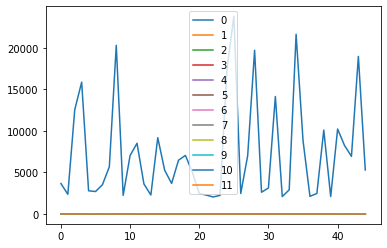

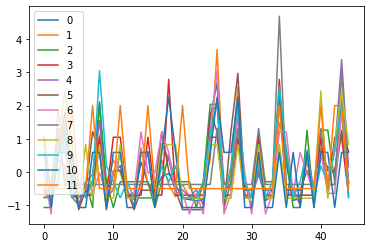

In [3]:
#validate best c on Slide 51

data = np.loadtxt('IAP_PAD2020/tons.dat')
data = pd.DataFrame(data)
data.plot()
plt.show
cols = list(data.columns)
zscore_data_pca = pd.DataFrame()
for col in cols:
        zscore_data_pca[col] = (data[col] - data[col].mean())/data[col].std(ddof=0)
zscore_data_pca.plot()

In [4]:
def center_(x, cluster):
    """ finds the centroid of a cluster
    X - the original data matrix
     cluster - the set with indices of the objects belonging to the cluster
    """
    #number of columns
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []
        for i in cluster:
            zc.append(zz[i])
        centroidC.append(np.mean(zc))
    return centroidC


def distNorm(x ,remains, ranges, p):
    """ Finds the normalized distances of data points in 'remains' to reference point 'p' 
     X - the original data matrix;
     remains- the set of X-row indices under consideration
     ranges- the vector with ranges of data features 
     p - the data point the distances relate to
     distan- the output column of distances from a to remains """

    #number of columns
    mm = x.shape[1]
    rr = len(remains)
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    distan = di
    return distan


def separCluster(x0, remains, ranges, a, b):
    """  Builds a cluster by splitting the points around refernce point 'a' from those around reference point b 
    x0 - data matrix
    remains- the set of X-row indices under consideration
    ranges- the vector with ranges of data features 
    a, b - the reference points
    cluster - set with row indices of the objects belonging to the cluster  
    """
    
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)
    clus = np.where(dista < distb)[0]
    cluster = []
    for i in clus:
        cluster.append(remains[i])
    return cluster

def anomalousPattern(x, remains, ranges, centroid, me):
    """ Builds one anomalous cluster based on the algorithm 'Separate/Conquer' (Mirkin, 1999, Machine Learning Journal) 
        X - data matrix,
        remains - set of its row indices (objects) under consideration,
        ranges - normalizing values: the vector with ranges of data features  
        centroid - initial center of the anomalous cluster being build
        me - vector to shift the 0 (origin) to,
        output: cluster - set of row indices in the anomalous cluster, 
        centroid -center of the cluster    """
        
    key = 1
    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0
    return (cluster, centroid)

def dist(x, remains, ranges, p):
    """ Calculates the normalized distances of data points in 'remains' to reference point 'p'   
        X - data matrix,
        remains - set of its row indices (objects) under consideration,
        ranges - normalizing values: the vector with ranges of data features  
    
       distan - the calculated normalized distances
    """

    #number of columns
    mm = x.shape[1]
    rr = len(remains)
    distan = np.zeros((rr,1))    
    for j in range(mm):
        z = x[:, j]
        z = z.reshape((-1,1))
        zz = z[remains]
        y = zz - p[j]
        y = y / ranges[j]
        y = np.array(y)
        yy = y * y
        distan = distan + yy
    return distan

def zscore(df):
    for col in list(df.columns):
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)
    return df

def init_data(which='air'):
    if which=='town':
        pass
    if which=='air':
        df = pd.read_csv('data_selection.csv')
        return zscore(df.iloc[:,5:])
    if which=='2d':
        df = pd.read_csv('data_selection.csv')
        return zscore(df.iloc[:,7:9])


In [5]:
##### ****** Main body for the Iterative Anomalous Cluster   *****
#### You should test and Validate it with Market Towns Data set    
# normalization FLAG
normalization = 0
# threshold value (this is an example)
threshold = 120

### I consider this from the PCA transformation

data_ap =  init_data('2d')# pandas dataframe
print(data_ap)
#data_ap =  zscore_data_pca.iloc[:,:-1]# pandas dataframe 
x = data_ap.values.astype(np.float32)
#y = data.target
#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]
print(mm)

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# data structure to keep everything together
ancl = []


for j in range(mm): # for each feature
    # use each row of the feature
    z = x[:, j]
    # add the mean to list of means
    me.append(np.mean(z))
    #add max to list of maxs
    mmax.append(np.max(z))
    #add min to list of mins
    mmin.append(np.min(z))
    if normalization:
        ranges.append(1);
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
sy = np.divide((x - me), ranges)
#standard error
sY = np.array(sy)
# sum of standard deviation?
d = np.sum(sY * sY)   # total data scatter of normalized data


# x, me range, d
remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # anomalous cluster counter
while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :] # initial anomalous center reference point
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d))   # cluster contribution, per cent 

    remains = np.setdiff1d(remains, cluster) 
    # update the data structure that keeps everything together
    ancl.append(cluster)   # set of data points in the cluster
    ancl.append(censtand)  # standardised centroid
    ancl.append(dD) # proportion of the data scatter
    
ancl = np.asarray(ancl)
ancl = ancl.reshape((numberC, 3))
##aK = numberC
b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik, 0]))
    
rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []
if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    print('number of clusters: ', len(rl))
    num_cents = 0
    for ik in range(numberC):
        cluster = ancl[ik,0]
        if(len(cluster) >= threshold):
            cent.append(ancl[ik, 1])
            num_cents += 1
                
cent = np.asarray(cent)
### Should be adapted
cent = cent.reshape((len(cent), len(data_ap.columns)))
print("Initial prototypes: \n", np.round(cent, 5))

init_partition = np.zeros((zscore_data_pca.shape[0], len(cent)))
for index, d in enumerate(zscore_data_pca):
    dists = [np.linalg.norm(d - c) for c in cent]
    assign = dists.index(np.min(dists))
    init_partition[index, assign] = 1



           SO2       NO2
0    -0.615605  1.202690
1    -0.662852  1.025913
2    -0.662852  0.981719
3    -0.710099  0.937525
4    -0.521110  1.246884
...        ...       ...
1356 -0.757347 -0.697656
1357 -0.662852 -0.476686
1358 -0.521110 -0.012648
1359 -0.426615  0.451390
1360 -0.521110  0.274614

[1361 rows x 2 columns]
2
number of clusters:  3
Initial prototypes: 
 [[ 0.12597  0.26244]
 [-0.08279 -0.20535]
 [-0.00867  0.10408]]


In [24]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#Here comes the fuzzy clustering!#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# First of all, we need to define our constraints and such
def constraint_membership(arr):
    for row in range(arr.shape[0]):
        if np.allclose(arr[row,:],np.ones_like(arr[row,:])):
            return False
    return True

# Matrix X (the fuzzy c-partition) consists of each data point in a cluster
# and their membership value which is contained in [0,1]
# which means we have a cxn matrix of k-tuples
# where k is the number of attributes our dataset has
# (I THINK)
def fuzzy_c_means(x, centers):
    # Secondly, we will define the parameters
    # number of clusters (renamed from sample code)
    num_clusters = num_cents
    # weighting exponent (Degree of fuzzification) m >=1.0 where 1.0 means crisp
    m = 2.0
    # maximum number of iterations T, arbitrarily capped at 100
    T = 100
    #Termination measure? E_t = norm(V_t -V_(t-1)) --> implemented as epsilon=.001
    #!!! V_t is a set of vectors of prototypes or centroids after t iterations

    # change in cluster centers compared to last 
    change_centers = np.linalg.norm(centers)

    # epsilon as termination factor as suggested in slides
    epsilon = 0.005
    # current iteration
    iteration = 0
    #HERE WE GO GUAISE
    axs = []
    while iteration <= T and change_centers > epsilon:
        old_centers = np.copy(centers)
        iteration += 1
        #print('*****\nStarting iteration no. {}\n*****'.format(iteration))

        # Calculate U_t - formula:
        #
        # (1 /  D_(ik)) ** (2/(m-1)) 
        # / sum_(j=1->c)(1/D_(jk)) ** 2/(m-1)
        #
        # D_(ik) = sqrt(norm(x_k - v_i))
        # check if this works! may have broadcasting errors
        distances = np.array(np.zeros((x.shape[0],centers.shape[0])))
        # calculate a new row in the distance matrix for each data point
        for center in range(centers.shape[0]):
            for row in range(x.shape[0]):
                distances_pt_to_ctrs = np.sqrt(np.linalg.norm(x[row,:] - centers[center,:]))
                distances[row, center] = distances_pt_to_ctrs


        # U_t is the membership matrix
        membership = np.zeros_like(distances)
        # Here's the plan
        # we calculate the membership function row-wise, that is
        # the sum of 
        for row in range(x.shape[0]):
            distance_to_clusters = (1/distances[row,:]) ** (2/(m-1))
            sum_distances_to_clusters = np.sum(distance_to_clusters)
            membership_row = distance_to_clusters / sum_distances_to_clusters
            membership[row,:] = membership_row
        assert constraint_membership(membership)
        # establish new centers
        #print('old centers')
        #print(centers)
        for center in range(centers.shape[0]):
            # membership[:,center] is a column containing the membership of each data point to that center
            factors = np.asarray(membership[:,center] ** m)
            factors_broadcast = np.asarray([factors for i in range(x.shape[1])])

            # we have to transpose for the element wise multiplication of two nxm matrices
            # axis = 0 to keep the dimensions
            centers[center,:] = np.sum(factors_broadcast.T * x, axis=0)\
                                / np.atleast_2d(np.sum(factors)).T
        #print('new center')
        #print(centers)
        change_centers = np.linalg.norm(centers - old_centers)
        #print('Change in centers: {}'.format(change_centers))
    return centers, membership, distances

**a)** 

- Study the fuzzy c-means (FCM) program in the software package of your choice.
- Apply the program to your dataset at the same c parameter with random seeds. Do this for several different values of parameter c= c_min, ..., c_max. Plot the FCM cost function versus c.

- Analyse the graphic and comment if any number of clusters better fits your data than the others.

2
[[0.32531224 0.37633364 0.38766229 ... 0.82789746 0.52162618 0.6614269 ]
 [0.67468776 0.62366636 0.61233771 ... 0.17210254 0.47837382 0.3385731 ]]
3
[[0.08473616 0.07153466 0.06825256 ... 0.05282918 0.03707681 0.05069693]
 [0.79359335 0.80183908 0.80507945 ... 0.47144597 0.84680605 0.71013415]
 [0.12167049 0.12662626 0.12666799 ... 0.47572485 0.11611714 0.23916892]]
4
[[0.47673041 0.39340644 0.37390396 ... 0.07997133 0.10134408 0.08858744]
 [0.05030336 0.04621393 0.04474725 ... 0.0201126  0.01533943 0.01700175]
 [0.37994979 0.45658252 0.47630884 ... 0.70455647 0.82519274 0.80125994]
 [0.09301644 0.10379711 0.10503995 ... 0.1953596  0.05812375 0.09315087]]
5
[[0.07451685 0.10129868 0.10611942 ... 0.03920085 0.08345914 0.05707523]
 [0.03360653 0.05471063 0.05942522 ... 0.09523069 0.06385438 0.07098088]
 [0.01533648 0.02068001 0.02151635 ... 0.00890459 0.01451122 0.01138148]
 [0.11275024 0.19985968 0.22399445 ... 0.81154408 0.69570983 0.77617208]
 [0.7637899  0.623451   0.58894456 ... 0

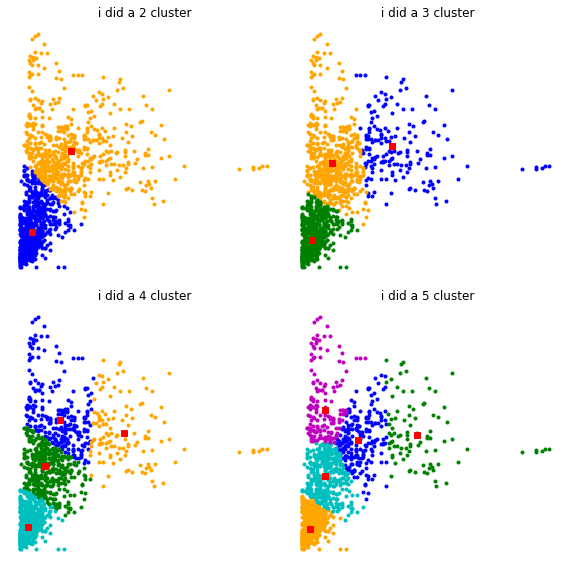

In [7]:
from __future__ import division, print_function
import skfuzzy as fuzz
colors = ['b', 'orange', 'g', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
# whatever may this number mean?
fig1, axes1 = plt.subplots(2,2, figsize=(8,8))
alldata = np.vstack((data_ap.iloc[:,0],data_ap.iloc[:,1]))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    print(ncenters)
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=100, init=None)
    
    #store fpc values for later
    fpcs.append(fpc)
    
    #plot assigned clusters, for each data point in set
    print(u)
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(data_ap.iloc[:,0][cluster_membership == j],
               data_ap.iloc[:,1][cluster_membership == j],
               '.', color=colors[j])
    
    #mark center of each cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')
        
    ax.set_title(' i did a {} cluster'.format(ncenters))
    ax.axis('off')
    
fig1.tight_layout()
print(fpcs)

2
0
1
3
0
1
2
4
0
1
2
3
5
0
1
2
3
4
[0.6271213379962364, 0.6271213379962364, 0.6271213379962364, 0.6271213379962364]


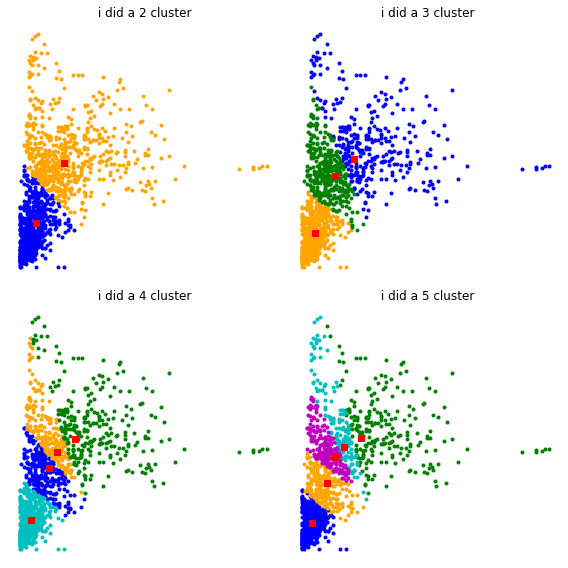

In [25]:
# now the same with my own c means implementation
colors = ['b', 'orange', 'g', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
# whatever may this number mean?
np.random.seed(28980)
fig1, axes1 = plt.subplots(2,2, figsize=(8,8))
alldata = pd.DataFrame(x)
fpcs = []
np.random.seed(28980)
for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    centers = np.random.rand(ncenters, alldata.shape[1])
    print(ncenters)
    centers, membership, distances = fuzzy_c_means(x, centers)
    
    #store fpc values for later
    fpcs.append(fpc)
    
    #plot assigned clusters, for each data point in set
    cluster_membership = np.argmax(membership, axis=1)
    for j in range(len(centers)):
        print(j)
        ax.plot(alldata[cluster_membership == j].iloc[:,0],
               alldata[cluster_membership == j].iloc[:,1],
               '.', color=colors[j])
    
    #mark center of each cluster
    for pt in centers:
        ax.plot(pt[0], pt[1], 'rs')
        
    ax.set_title(' i did a {} cluster'.format(ncenters))
    ax.axis('off')
    
fig1.tight_layout()
print(fpcs)

**b)**
- Study the Anomalous Pattern (AP) clustering algorithm. 
- Test the implementation with the benchmark data sets provided to you.

,0,1
0,-0.615605,1.202690
1,-0.662852,1.025913
2,-0.662852,0.981719
3,-0.710099,0.937525
4,-0.521110,1.246884
...,...,...
1328,0.045859,0.849137
1332,-0.521110,0.517681
1333,-0.568357,1.092204
1334,-0.568357,1.268981


**c)** 
- Take the Anomalous Clustering as the initialization algorithm to the fuzzy c-means and apply the Anomalous Patterns_FCM (AP-FCM) to your data set.
- Discuss the options taken for setting the AP parameters. Present and visualize the found fuzzy partitions of AP-FCM.

**d)**
- Discuss the results obtained by Anomalous Patterns FCM for your data case respecting the following: 
    - (i) location of the initial prototypes
    - (ii) choice of the number of clusters.

**e)**
- Apply, at least, two validation indices, like the *Adjust Rand Index (ARI)* and *Xie-Beni*, to access the quality of the fuzzy c-partitions obtained in **a)**. 
- Compare these results with the one of Anomalous Patterns FCM getting in **c)**.

**f)**
- Make an interpretation of the found clusters by the AnomalousPatterns_FCM for your data as discussed in the classes.